# PySpark: Analysis of sales data stored in Parquet file format. 

### What was the best month in sales?
### What city has the highest sales?
### What time should we display advertisements to maximize the likelihood of customer's buying products?
### What's often sold together in the state of NY

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
#create spark session
spark = (SparkSession.builder.appName('SalesAnalytics').getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/05 16:39:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Java11 and Spark 3.2 when used together produce these errors. 
The first step is to switch to Java8 until this issue gets resolved, although spark session is still created and runs successfully

## Read 2019 Data from Parquet FIles Directory

In [4]:
#set the filepath and partition
source_data_path = 'data/output/sales/'
partition = 'ReportYear=2019'
full_path = f'{source_data_path}{partition}'

In [5]:
#read parquet file
sales_2019_df = spark.read.parquet(full_path)
sales_2019_df.show(5,truncate = False)

+-------+------------------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+
|OrderID|Product                 |Quantity|Price |OrderDate          |StoreAddress                       |City          |State|Month|
+-------+------------------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+
|295838 |34in Ultrawide Monitor  |1       |379.99|2019-12-14 22:57:00|321 8th St, San Francisco, CA 94016| San Francisco|CA   |12   |
|296598 |AAA Batteries (4-pack)  |3       |2.99  |2019-12-23 10:08:00|757 Lake St, Seattle, WA 98101     | Seattle      |WA   |12   |
|296803 |Lightning Charging Cable|1       |14.95 |2019-12-03 10:10:00|598 4th St, Los Angeles, CA 90001  | Los Angeles  |CA   |12   |
|297378 |Apple Airpods Headphones|1       |150.0 |2019-12-19 10:12:00|991 4th St, Dallas, TX 75001       | Dallas       |TX   |12   |
|297643 |ThinkPad Laptop         |1       |999.99|2019-12-24 1

## What was the best month in sales?

In [6]:
from pyspark.sql.functions import round, sum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sales_q1_df = (sales_2019_df.select(
                                col('OrderID'),
                                col('Month'),
                                col('Price'),
                                col('Quantity'),
                                expr('Price * Quantity').alias('Sales')))

In [8]:
sales_q1_df.show()

+-------+-----+------+--------+----------+
|OrderID|Month| Price|Quantity|     Sales|
+-------+-----+------+--------+----------+
| 295838|   12|379.99|       1|    379.99|
| 296598|   12|  2.99|       3|      8.97|
| 296803|   12| 14.95|       1|     14.95|
| 297378|   12| 150.0|       1|     150.0|
| 297643|   12|999.99|       1|    999.99|
| 298114|   12|  3.84|       1|      3.84|
| 298177|   12|  3.84|       3|11.5199995|
| 298662|   12| 600.0|       1|     600.0|
| 298747|   12| 11.95|       1|     11.95|
| 298793|   12| 14.95|       1|     14.95|
| 299117|   12| 11.95|       1|     11.95|
| 299247|   12| 14.95|       1|     14.95|
| 299885|   12| 11.99|       1|     11.99|
| 300057|   12| 14.95|       1|     14.95|
| 300393|   12| 11.95|       1|     11.95|
| 300480|   12| 400.0|       1|     400.0|
| 300623|   12| 11.95|       1|     11.95|
| 300683|   12| 11.95|       1|     11.95|
| 300713|   12|379.99|       1|    379.99|
| 300876|   12| 14.95|       1|     14.95|
+-------+--

In [9]:
#calculate total sales by month
sales_q1_df = (sales_q1_df
               .groupBy('Month')
               .agg(round(sum('Sales'),2).alias('TotalSales'))
               .orderBy('TotalSales', ascending = False))

In [10]:
sales_q1_df.show()

+-----+----------+
|Month|TotalSales|
+-----+----------+
|   12|4608295.68|
|   10|3734777.84|
|    4|3389217.96|
|   11|3197875.03|
|    5|3150616.21|
|    3|2804973.34|
|    7|2646461.31|
|    6|2576280.14|
|    8|2241083.36|
|    2|2200078.07|
|    9|2094465.68|
|    1|1812742.86|
+-----+----------+



In [11]:
#convert spark df to pandas
pd_sales_q1 = (sales_q1_df.orderBy('Month')).toPandas()

In [12]:
pd_sales_q1

,Month,TotalSales
0,1,1812742.86
1,2,2200078.07
2,3,2804973.34
3,4,3389217.96
4,5,3150616.21
5,6,2576280.14
6,7,2646461.31
7,8,2241083.36
8,9,2094465.68
9,10,3734777.84


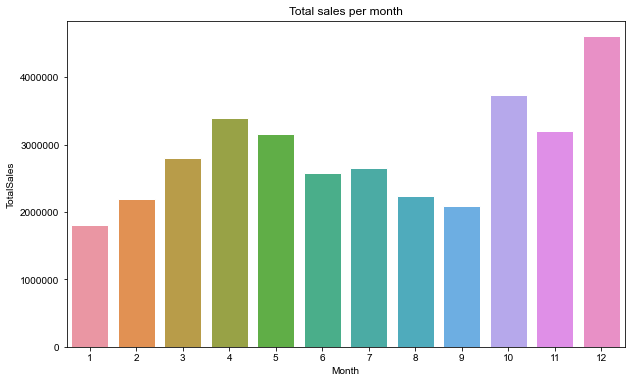

In [13]:
plt.figure(figsize= (10,6))
plt.ticklabel_format(useOffset=False, style = 'plain')
sns.set_theme(style = 'whitegrid')
sns.barplot(x = 'Month', y = 'TotalSales', data=pd_sales_q1).set_title('Total sales per month')
plt.ylabel('TotalSales')
plt.show()

## What city has the highest sales?

In [14]:
sales_2019_df.show()

+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
|OrderID|             Product|Quantity| Price|          OrderDate|        StoreAddress|          City|State|Month|
+-------+--------------------+--------+------+-------------------+--------------------+--------------+-----+-----+
| 295838|34in Ultrawide Mo...|       1|379.99|2019-12-14 22:57:00|321 8th St, San F...| San Francisco|   CA|   12|
| 296598|AAA Batteries (4-...|       3|  2.99|2019-12-23 10:08:00|757 Lake St, Seat...|       Seattle|   WA|   12|
| 296803|Lightning Chargin...|       1| 14.95|2019-12-03 10:10:00|598 4th St, Los A...|   Los Angeles|   CA|   12|
| 297378|Apple Airpods Hea...|       1| 150.0|2019-12-19 10:12:00|991 4th St, Dalla...|        Dallas|   TX|   12|
| 297643|     ThinkPad Laptop|       1|999.99|2019-12-24 19:00:00|27 Maple St, Bost...|        Boston|   MA|   12|
| 298114|AA Batteries (4-p...|       1|  3.84|2019-12-22 01:57:00|259 Johnson St

In [15]:
sales_2019_df.select('OrderID', 'Quantity', 'City').show()

+-------+--------+--------------+
|OrderID|Quantity|          City|
+-------+--------+--------------+
| 295838|       1| San Francisco|
| 296598|       3|       Seattle|
| 296803|       1|   Los Angeles|
| 297378|       1|        Dallas|
| 297643|       1|        Boston|
| 298114|       1|       Atlanta|
| 298177|       3|       Seattle|
| 298662|       1| San Francisco|
| 298747|       1|      Portland|
| 298793|       1|        Boston|
| 299117|       1|   Los Angeles|
| 299247|       1| San Francisco|
| 299885|       1|        Boston|
| 300057|       1|   Los Angeles|
| 300393|       1|        Dallas|
| 300480|       1| New York City|
| 300623|       1| New York City|
| 300683|       1| San Francisco|
| 300713|       1|      Portland|
| 300876|       1|       Seattle|
+-------+--------+--------------+
only showing top 20 rows



In [16]:
sales_q2_df = (sales_2019_df.groupBy('City')
              .agg(sum('Quantity').alias('TotalProducts'))
              .orderBy('TotalProducts', ascending = False))

In [17]:
sales_q2_df.show(10)

+--------------+-------------+
|          City|TotalProducts|
+--------------+-------------+
| San Francisco|        50156|
|   Los Angeles|        33246|
| New York City|        27887|
|        Boston|        22490|
|        Dallas|        16705|
|       Atlanta|        16584|
|       Seattle|        16533|
|      Portland|        14035|
|        Austin|        11135|
+--------------+-------------+



In [18]:
pd_sales_q2 = sales_q2_df.toPandas()

In [19]:
pd_sales_q2

,City,TotalProducts
0,San Francisco,50156
1,Los Angeles,33246
2,New York City,27887
3,Boston,22490
4,Dallas,16705
5,Atlanta,16584
6,Seattle,16533
7,Portland,14035
8,Austin,11135


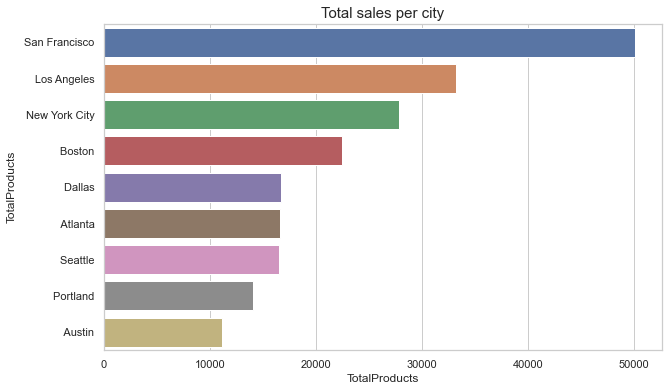

In [20]:
plt.figure(figsize= (10,6))
plt.ticklabel_format(useOffset=False, style = 'plain')
sns.set_theme(style = 'whitegrid')
sns.barplot(y = 'City', x = 'TotalProducts', data=pd_sales_q2).set_title('Total sales per city', fontsize = 15)
plt.ylabel('TotalProducts')
plt.show()

## What time should we display advertisements to maximize the likelihood of customer's buying products?

In [21]:
from pyspark.sql.functions import count, date_format

In [22]:
#no of times
sales_2019_df.groupBy('OrderID').agg(count('OrderID').alias('count')).where(col('count') > 1).show(10, False)

+-------+-----+
|OrderID|count|
+-------+-----+
|310188 |2    |
|304276 |2    |
|269251 |2    |
|300601 |2    |
|285602 |2    |
|265863 |2    |
|261569 |2    |
|277349 |2    |
|188122 |2    |
|310537 |2    |
+-------+-----+
only showing top 10 rows



In [23]:
sales_2019_df.filter(col('OrderID') == 304276).show(truncate =False)

+-------+---------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+
|OrderID|Product        |Quantity|Price |OrderDate          |StoreAddress                       |City          |State|Month|
+-------+---------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+
|304276 |iPhone         |1       |700.0 |2019-12-15 06:07:00|358 5th St, New York City, NY 10001| New York City|NY   |12   |
|304276 |ThinkPad Laptop|1       |999.99|2019-12-15 06:07:00|358 5th St, New York City, NY 10001| New York City|NY   |12   |
+-------+---------------+--------+------+-------------------+-----------------------------------+--------------+-----+-----+



In [24]:
#no of orders by hour
sales_q3_df = (sales_2019_df.select('OrderID'
                        ,date_format('OrderDate', 'HH').cast('int').alias('Hour'))
                       .distinct()
                       .groupBy('Hour')
                       .agg(count('Hour').alias('TotalOrders'))
                       .orderBy(col('TotalOrders'), ascending = False))

In [25]:
sales_q3_df.show(10)

+----+-----------+
|Hour|TotalOrders|
+----+-----------+
|  19|      12377|
|  12|      12082|
|  11|      11882|
|  20|      11763|
|  18|      11761|
|  13|      11682|
|  14|      10522|
|  21|      10499|
|  10|      10492|
|  17|      10476|
+----+-----------+
only showing top 10 rows



In [26]:
pd_sales_q3 = sales_q3_df.orderBy('Hour').toPandas()

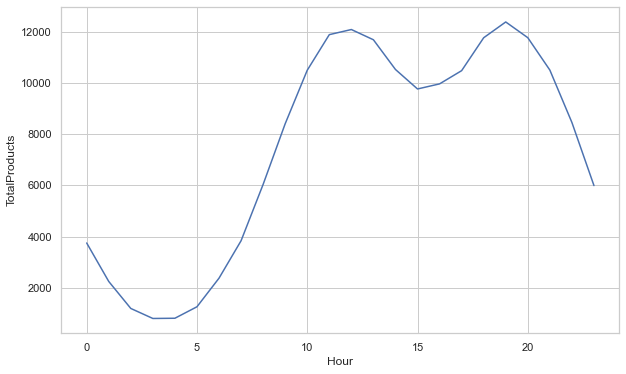

In [27]:
#line chart Totalproducts sold by Hour
plt.figure(figsize= (10,6))
plt.ticklabel_format(useOffset=False, style = 'plain')
sns.set_theme(style = 'whitegrid')
sns.lineplot(x = 'Hour', y = 'TotalOrders', data=pd_sales_q3)
plt.ylabel('TotalProducts')
plt.show()

## What's often sold together in the state of NY

In [28]:
from pyspark.sql.functions import collect_list, size

In [29]:
#filter for newyork 
#convert product into a list with collect_list function
sales_q4_df = (sales_2019_df.where(col('State') == 'NY').orderBy('OrderID', 'Product').groupBy('OrderID', 'State')
                              .agg(collect_list('Product').alias('ProductList')))

In [30]:
sales_q4_df.show(10, truncate = False)

+-------+-----+----------------------------+
|OrderID|State|ProductList                 |
+-------+-----+----------------------------+
|141264 |NY   |[Apple Airpods Headphones]  |
|141268 |NY   |[AA Batteries (4-pack)]     |
|141272 |NY   |[AAA Batteries (4-pack)]    |
|141278 |NY   |[Lightning Charging Cable]  |
|141282 |NY   |[Vareebadd Phone]           |
|141301 |NY   |[Apple Airpods Headphones]  |
|141314 |NY   |[Macbook Pro Laptop]        |
|141317 |NY   |[27in FHD Monitor]          |
|141323 |NY   |[USB-C Charging Cable]      |
|141343 |NY   |[Bose SoundSport Headphones]|
+-------+-----+----------------------------+
only showing top 10 rows



In [31]:
#create a column with no of products per order ID
sales_q4_df = (sales_q4_df.withColumn('ProductListSize', size('ProductList')))
#filter for productlistsize > 1
sales_q4_df.filter(col('ProductListSize') > 1).orderBy('ProductList').show(10, False)

+-------+-----+----------------------------------------+---------------+
|OrderID|State|ProductList                             |ProductListSize|
+-------+-----+----------------------------------------+---------------+
|253929 |NY   |[20in Monitor, 27in 4K Gaming Monitor]  |2              |
|197004 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|158102 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|248053 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|266247 |NY   |[20in Monitor, AA Batteries (4-pack)]   |2              |
|176251 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|245465 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|194762 |NY   |[20in Monitor, AAA Batteries (4-pack)]  |2              |
|204645 |NY   |[20in Monitor, Apple Airpods Headphones]|2              |
|234956 |NY   |[20in Monitor, Apple Airpods Headphones]|2              |
+-------+-----+------------------------------------

In [32]:
## No of times sets of products were sold together
(sales_q4_df.filter(col('ProductListSize') > 1)
                  .groupBy('ProductList')
                  .count()
                  .orderBy('count', ascending = False)).show(20, False)

+------------------------------------------------------+-----+
|ProductList                                           |count|
+------------------------------------------------------+-----+
|[Google Phone, USB-C Charging Cable]                  |127  |
|[Lightning Charging Cable, iPhone]                    |126  |
|[Google Phone, Wired Headphones]                      |53   |
|[USB-C Charging Cable, Vareebadd Phone]               |50   |
|[Wired Headphones, iPhone]                            |46   |
|[Apple Airpods Headphones, iPhone]                    |45   |
|[Bose SoundSport Headphones, Google Phone]            |24   |
|[Apple Airpods Headphones, Wired Headphones]          |19   |
|[Vareebadd Phone, Wired Headphones]                   |17   |
|[AAA Batteries (4-pack), Lightning Charging Cable]    |16   |
|[AA Batteries (4-pack), Lightning Charging Cable]     |16   |
|[USB-C Charging Cable, Wired Headphones]              |14   |
|[AA Batteries (4-pack), AAA Batteries (4-pack)]       